In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
import re
%matplotlib inline

### Settings

In [2]:
# Path settings
base_path_to_csv = "/home/till/SharedFolder/trained_models/night-drive/weather_classifier/"

# Settings for epoch selection method
which_mode = "best_onemetric"  # Options: ["manual", "common", "best_onemetric", "best_eachmetric"]
# epoch to use for mode "common" epoch
epoch_common = 40  # Options: [1, 40]
# metric to use for mode "best_onemetric"
onemetric = "pr_macro" # "accuracy_balanced"  # Options: ['f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'accuracy', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc', 'train_loss', 'train_dev_loss']
# manual list of epochs for mode "manual"
list_selepochs = [[10, 10, 13, 10, 13, 10], # for each trial of run "without_cloudy"
                  [10, 10, 10, 10, 10, 10]] # for each trial of run "with_cloudy"

### Select classifier results

In [3]:
# load results and pick best epochs
# for each run and trial, these results contain a variety of metrics for all epochs for all sub-splits (train, valid, etc)
df_sel = pd.DataFrame()
df_sel_epochs = pd.DataFrame()
df_all = pd.DataFrame()
list_runs = ["without_cloudy", "with_cloudy"]
list_trials = ["train_A_over", "train_B_over", "train_C_over", "train_A_over_ganaug_025", "train_A_over_ganaug_050", "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase"]
onemetric_store = onemetric
for r, run in enumerate(list_runs):  # for each set of classifier runs
    if which_mode == "best_onemetric" and run == "with_cloudy" and onemetric == "accuracy_balanced":
        onemetric_store = onemetric
        onemetric = "accuracy"
    else:
        onemetric = onemetric_store
        
    for t, trial in enumerate(list_trials):  # for each data set
        path_to_csv = os.path.join(base_path_to_csv,run,trial)
        csv_files = glob.glob(path_to_csv + "/*.csv")
        ### Combine CSVs into one DataFrame ###
        df = pd.DataFrame()
        for csv_file in csv_files:
            df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
            df = df.reset_index(drop = True)
        ### Some preprocessing ###
        #
        df = df.drop(columns = ["weights"])
        #
        df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
        df = df.sort_values(by = ["data", "epoch"])
        df = df.reset_index(drop = True)
        ### Load training log file ###
        train_log_file = glob.glob(path_to_csv + "/*.txt")
        assert(len(train_log_file) == 1)
        df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
        df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
        df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
        df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
        df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
        df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
        ### Combine loss, scores
        df_combined = df_loss.groupby(by = ["epoch"]).median()
        df_combined = df_combined.drop(columns = ["batch"])
        ### Combine loss, scores into metrics
        # df = df.join(df_combined, on="epoch")
        # stash best results according to selected method
        if which_mode in ["manual", "common"]:
            if which_mode == "manual":  # manual list of epochs, e.g. balancing overfitting and performance
                sel_epoch = list_selepochs[r][t]
            elif which_mode == "common":  # same epoch for every run
                sel_epoch = epoch_common
            rw = df.query("epoch==@sel_epoch").copy()
            rw.loc[:, "trial"] = list_trials[t]
            rw.loc[:, "run"] = list_runs[r]
            df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_onemetric":  # for each run, the best epoch accoding to one metric is selected 
            sel_epoch = []
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                rw = df_subsplit.loc[df_subsplit[onemetric].idxmax(), :].to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_eachmetric":  # all runs and metrics are evaluated independently on their best epoch 
            # find best epoch metric for each metric
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                sel_epochs = df_subsplit.loc[:,df_subsplit.columns[df_subsplit.dtypes == "float64"]].idxmax().to_frame().T
                sel_epochs.loc[:, "trial"] = list_trials[t]
                sel_epochs.loc[:, "run"] = list_runs[r]
                rw = df_subsplit.max().to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel_epochs = df_sel_epochs.append(sel_epochs, ignore_index=True, sort=True) 
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 

        # stash all data
        df_all = pd.concat([df_all, df], axis=1)

In [4]:
df.head(5)

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.416610,0.357603,0.362211,0.357603,0.507598,0.558730,0.758074,0.418042,0.556142,0.217372
1,2,test,0.617604,0.548325,0.515300,0.548325,0.635635,0.775693,0.860508,0.653937,0.708613,0.354225
2,3,test,0.773570,0.740335,0.637989,0.740335,0.716836,0.897251,0.894623,0.825988,0.769045,0.483436
3,4,test,0.813300,0.795103,0.678030,0.795103,0.735718,0.926422,0.905948,0.873937,0.792658,0.536706
4,5,test,0.811756,0.793814,0.676484,0.793814,0.736812,0.929515,0.910921,0.878833,0.803043,0.535187


In [5]:
df_sel.head(5)

,accuracy,accuracy_balanced,data,epoch,f1_score_macro,f1_score_micro,f1_score_weighted,mcc,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro,run,trial
0,0.878866,0.80297,test,12,0.783353,0.878866,0.881799,0.680954,0.858218,0.937273,0.932414,0.96398,without_cloudy,train_A_over
1,0.931894,0.911488,test_daytime,32,0.901494,0.931894,0.932434,0.857395,0.959121,0.980361,0.987219,0.989223,without_cloudy,train_A_over
2,0.850526,0.668717,test_night,12,0.662524,0.850526,0.85476,0.492038,0.715868,0.902459,0.851362,0.94458,without_cloudy,train_A_over
3,0.923899,0.92391,train_dev_A_over,12,0.923793,0.923899,0.923793,0.886022,0.972457,0.973417,0.98534,0.984951,without_cloudy,train_A_over
4,0.891108,0.804895,valid,18,0.792513,0.891108,0.892714,0.707676,0.859847,0.948565,0.940276,0.97083,without_cloudy,train_A_over


In [6]:
# print best epochs for each metric, if available
if which_mode == "best_eachmetric":
    print(df_sel_epochs.head(12))

### Print results for best epochs gouped by split

In [7]:
# Selection (and order) of columns to be printed
meta2print = ["epoch", "trial", "run"]
metrics2print = ['accuracy', 'accuracy_balanced', 'f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc']
cols2print = [*meta2print, *metrics2print]
# rename train dev sets
df_sel.data = df_sel.data.apply(lambda x: re.sub(r"_[A-C]_[a-zA-Z0-9_]*", r"", x))

#### Valid-All

In [8]:
split = "valid"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "=== Results for best manual epoch ===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid === Results for best manual epoch ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,18,train_A_over,without_cloudy,0.891108,0.804895,0.892714,0.891108,0.792513,0.97083,0.940276,0.948565,0.859847,0.707676
1,10,train_B_over,without_cloudy,0.87951,0.838995,0.885244,0.87951,0.789752,0.966619,0.958618,0.939962,0.884118,0.70468
2,18,train_C_over,without_cloudy,0.876289,0.83805,0.883146,0.876289,0.785799,0.965327,0.958734,0.936969,0.882341,0.700331
3,17,train_A_over_ganaug_025,without_cloudy,0.884021,0.806947,0.887415,0.884021,0.782404,0.969425,0.945387,0.945687,0.862335,0.697852
4,13,train_A_over_ganaug_050,without_cloudy,0.865979,0.81133,0.872812,0.865979,0.767316,0.960684,0.942798,0.931224,0.857608,0.669465
5,28,train_B_over_ganaug_025,without_cloudy,0.911082,0.825168,0.910738,0.911082,0.828931,0.978057,0.955146,0.961464,0.887026,0.753085
6,24,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.893041,0.791875,0.893047,0.893041,0.791843,0.972422,0.940824,0.951744,0.853392,0.705072
7,16,train_A_over,with_cloudy,0.8175,NaN,0.820119,0.8175,0.73887,0.949464,0.928556,0.87274,0.81191,0.680891
8,16,train_B_over,with_cloudy,0.8325,NaN,0.833933,0.8325,0.77168,0.956511,0.944041,0.894839,0.84711,0.708308
9,20,train_C_over,with_cloudy,0.818,NaN,0.822459,0.818,0.753939,0.951981,0.942564,0.883151,0.8397,0.690515


#### Valid-Night

In [9]:
split = "valid_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid_night ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,11,train_A_over,without_cloudy,0.844211,0.705942,0.856037,0.844211,0.662271,0.944157,0.875442,0.900467,0.738081,0.52799
1,10,train_B_over,without_cloudy,0.858947,0.766605,0.868659,0.858947,0.705202,0.952848,0.923778,0.912991,0.8094,0.579326
2,15,train_C_over,without_cloudy,0.851579,0.779548,0.863797,0.851579,0.705662,0.95406,0.932297,0.915159,0.8238,0.575132
3,15,train_A_over_ganaug_025,without_cloudy,0.848421,0.711582,0.857638,0.848421,0.669856,0.949796,0.891163,0.907739,0.742771,0.530553
4,25,train_A_over_ganaug_050,without_cloudy,0.846316,0.730243,0.856993,0.846316,0.678799,0.947129,0.890251,0.907876,0.749144,0.536388
5,16,train_B_over_ganaug_025,without_cloudy,0.909474,0.731702,0.905769,0.909474,0.764906,0.97212,0.913236,0.951131,0.808342,0.658809
6,24,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.876842,0.659562,0.8731,0.876842,0.678982,0.960197,0.871846,0.930401,0.712757,0.542073
7,14,train_A_over,with_cloudy,0.816,NaN,0.820186,0.816,0.604108,0.937641,0.835894,0.844601,0.653646,0.485189
8,16,train_B_over,with_cloudy,0.854,NaN,0.856341,0.854,0.692809,0.957802,0.89506,0.903168,0.745281,0.594282
9,17,train_C_over,with_cloudy,0.819,NaN,0.829585,0.819,0.655459,0.947624,0.900617,0.877203,0.748335,0.556378


In [10]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== valid_night Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,0,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,-1,train_B_over,without_cloudy,0.0147368,0.060663,0.0126222,0.0147368,0.0429315,0.00869086,0.0483353,0.0125231,0.0713189,0.0513361
2,4,train_C_over,without_cloudy,0.00736842,0.0736063,0.00775963,0.00736842,0.043391,0.00990305,0.0568548,0.0146918,0.0857196,0.0471423
3,4,train_A_over_ganaug_025,without_cloudy,0.00421053,0.00564067,0.00160085,0.00421053,0.00758556,0.00563934,0.015721,0.00727113,0.00469052,0.00256338
4,14,train_A_over_ganaug_050,without_cloudy,0.00210526,0.0243011,0.000955822,0.00210526,0.0165283,0.00297175,0.0148086,0.0074086,0.0110631,0.00839842
5,5,train_B_over_ganaug_025,without_cloudy,0.0652632,0.0257597,0.0497315,0.0652632,0.102636,0.0279629,0.037794,0.0506633,0.0702615,0.130819
6,13,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.0326316,-0.0463798,0.0170628,0.0326316,0.0167109,0.0160399,-0.00359659,0.0299332,-0.0253236,0.0140835
7,0,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,2,train_B_over,with_cloudy,0.038,NaN,0.0361552,0.038,0.088701,0.0201603,0.0591659,0.0585671,0.0916356,0.109092
9,3,train_C_over,with_cloudy,0.003,NaN,0.00939908,0.003,0.0513511,0.009983,0.0647236,0.032602,0.0946895,0.0711885


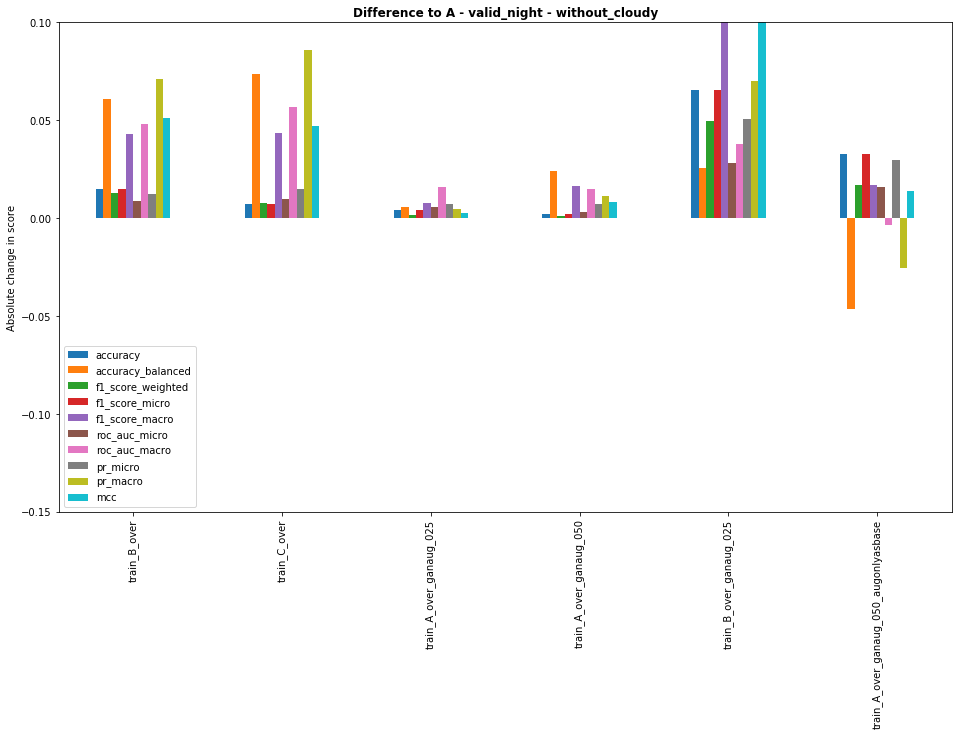

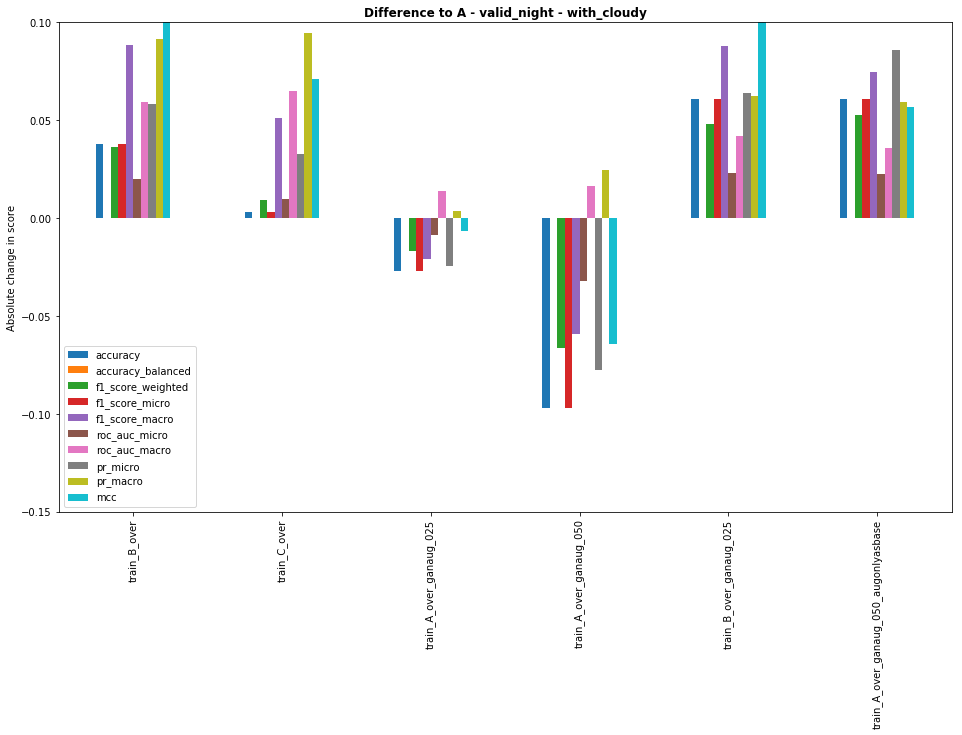

In [11]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")

#### Test-All

In [12]:
split = "test"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,12,train_A_over,without_cloudy,0.878866,0.80297,0.881799,0.878866,0.783353,0.96398,0.932414,0.937273,0.858218,0.680954
1,26,train_B_over,without_cloudy,0.895619,0.839788,0.898231,0.895619,0.812055,0.972689,0.946767,0.951144,0.884097,0.729024
2,21,train_C_over,without_cloudy,0.881443,0.835541,0.885967,0.881443,0.793828,0.967136,0.950204,0.940757,0.881354,0.703633
3,15,train_A_over_ganaug_025,without_cloudy,0.868557,0.805292,0.873609,0.868557,0.768419,0.961408,0.933471,0.932827,0.851916,0.668155
4,27,train_A_over_ganaug_050,without_cloudy,0.878222,0.804054,0.881682,0.878222,0.777937,0.964858,0.933234,0.93894,0.850827,0.68384
5,20,train_B_over_ganaug_025,without_cloudy,0.906572,0.817615,0.906325,0.906572,0.819581,0.973678,0.943984,0.954122,0.875273,0.741465
6,23,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.89433,0.785715,0.893308,0.89433,0.795694,0.969967,0.932078,0.947709,0.852153,0.703022
7,20,train_A_over,with_cloudy,0.8325,NaN,0.834612,0.8325,0.76251,0.956025,0.934289,0.891641,0.835361,0.707121
8,35,train_B_over,with_cloudy,0.8555,NaN,0.855876,0.8555,0.793282,0.962279,0.94287,0.902924,0.847821,0.745822
9,35,train_C_over,with_cloudy,0.85,NaN,0.850954,0.85,0.782636,0.961269,0.944,0.90301,0.850694,0.736677


#### Test-Night

In [13]:
split = "test_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test_night ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,12,train_A_over,without_cloudy,0.850526,0.668717,0.85476,0.850526,0.662524,0.94458,0.851362,0.902459,0.715868,0.492038
1,26,train_B_over,without_cloudy,0.877895,0.769824,0.882988,0.877895,0.730436,0.959771,0.893492,0.924338,0.793323,0.609382
2,15,train_C_over,without_cloudy,0.849474,0.766524,0.860576,0.849474,0.697485,0.948705,0.900046,0.900367,0.793724,0.56125
3,10,train_A_over_ganaug_025,without_cloudy,0.816842,0.694612,0.834111,0.816842,0.635114,0.932113,0.860365,0.881158,0.720191,0.477988
4,10,train_A_over_ganaug_050,without_cloudy,0.808421,0.714902,0.828772,0.808421,0.634119,0.925183,0.862101,0.868497,0.725403,0.484413
5,40,train_B_over_ganaug_025,without_cloudy,0.901053,0.724217,0.89867,0.901053,0.742339,0.965084,0.890424,0.936863,0.779434,0.636268
6,21,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.871579,0.657243,0.867908,0.871579,0.674993,0.952351,0.848969,0.914455,0.68698,0.523595
7,26,train_A_over,with_cloudy,0.855,NaN,0.845046,0.855,0.632001,0.952225,0.848743,0.890011,0.683847,0.546848
8,19,train_B_over,with_cloudy,0.858,NaN,0.860423,0.858,0.694585,0.954401,0.890487,0.883683,0.749733,0.609774
9,23,train_C_over,with_cloudy,0.852,NaN,0.850299,0.852,0.657342,0.952888,0.891628,0.881518,0.750903,0.582742


In [14]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== test_night Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,0,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,14,train_B_over,without_cloudy,0.0273684,0.101107,0.0282283,0.0273684,0.0679116,0.0151911,0.04213,0.0218788,0.077455,0.117344
2,3,train_C_over,without_cloudy,-0.00105263,0.0978067,0.00581576,-0.00105263,0.0349607,0.00412521,0.0486837,-0.00209218,0.0778563,0.0692122
3,-2,train_A_over_ganaug_025,without_cloudy,-0.0336842,0.0258951,-0.0206491,-0.0336842,-0.0274096,-0.0124665,0.00900292,-0.0213011,0.00432308,-0.0140499
4,-2,train_A_over_ganaug_050,without_cloudy,-0.0421053,0.0461847,-0.0259875,-0.0421053,-0.0284048,-0.0193967,0.0107392,-0.0339617,0.00953509,-0.00762428
5,28,train_B_over_ganaug_025,without_cloudy,0.0505263,0.0555,0.0439102,0.0505263,0.0798151,0.0205042,0.0390622,0.0344038,0.0635659,0.14423
6,9,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.0210526,-0.0114739,0.0131478,0.0210526,0.0124687,0.00777175,-0.0023926,0.0119956,-0.0288881,0.0315572
7,0,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,-7,train_B_over,with_cloudy,0.003,NaN,0.0153766,0.003,0.0625841,0.00217567,0.0417433,-0.00632862,0.0658859,0.0629255
9,-3,train_C_over,with_cloudy,-0.003,NaN,0.00525296,-0.003,0.0253412,0.0006625,0.0428849,-0.00849348,0.0670557,0.0358938


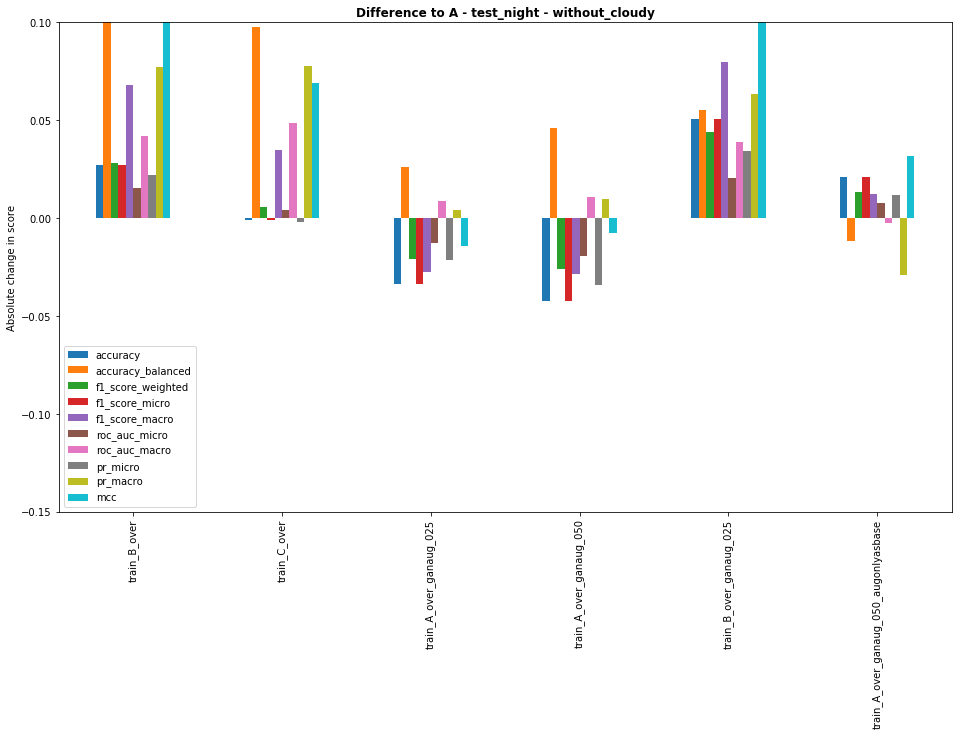

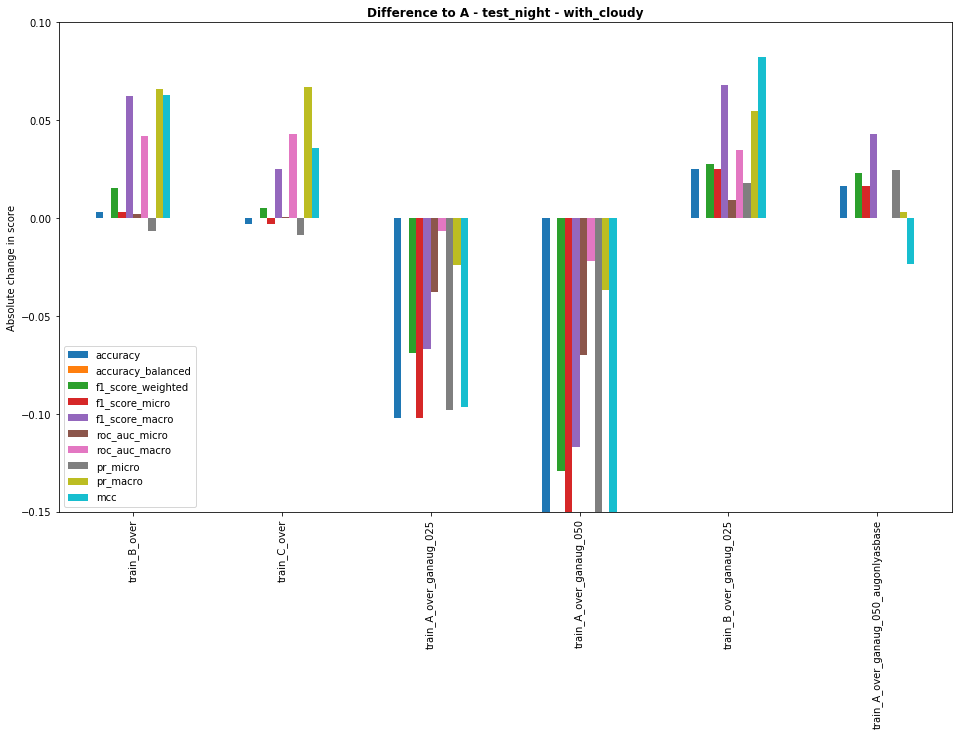

In [15]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")